# Lecture 1: Introduction to Machine Learning

In this lecture, we will introduce the basics of machine learning.

Let's start by exploring what neural network training looks like under the hood.

## Part 1: Backpropagation

Backpropagation algorithm is the cornerstone of training neural networks. (used in all neural nets) It is a method to calculate the gradient of the loss function with respect to the weights of the network.

**The main problem is... how do computers compute the gradient?**

Humans get the gradient by calculating the derivative, then plug in the values.

Computers can't do that:
1. Derivatives are hard to calculate
2. Neural networks are huge

Let's build our own backpropagation algorithm from scratch step by step.



In [18]:
# Importing libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt

### Manual Gradient Calculation

Let's manually calculate the gradient of a function.

#### Example 1: Single Variable Function

In [19]:
# Define a random function
# f(x) = 3x^2 - 4x + 5
def f(x):
    # ------------------
    # Write your implementation here.
    out = 3 * x ** 2 - 4 * x + 5
    # ------------------
    return out

In [20]:
f(2)  # f(2) = 3*2^2 - 4*2 + 5 = 9

9

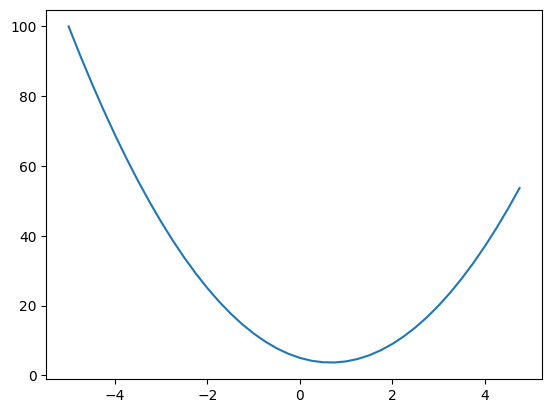

In [21]:
# Plot the function
xs = np.arange(-5, 5, 0.25)  # np.arange(start, stop, step)
ys = [f(x) for x in xs]
plt.plot(xs, ys)

What is the gradient of f(x) at x=2?
- Human's solution:
    - f'(x) = 6x - 4
    - f'(2) = 6*2 - 4 = 8'

- Computer's solution:
    - f'(2) = (f(2 + h) - f(2)) / h
        - h: a small number (0.0001)

In [22]:
def gradient(function, x, _h=0.0001):
    # ------------------
    # Write your implementation here.
    grad = (function(x + _h) - function(x)) / _h
    # ------------------
    return grad

In [23]:
gradient(f, 2)

8.000300000023941

Let's calculate the gradient of a more complex function.

![(x + y) * z](../../assets/(x+y)z.png)

(Image credit: Stanford CS231n)

#### Example 2: Multi-Variable Function

In [24]:
def f(x, y, z):
    out = (x + y) * z
    return out

In [25]:
f(-2, 5, -4)  # f(-2, 5, -4) = (-2 + 5) * -4 = -12

-12

Let's calculate the gradient of this function

**Goal**:
1. df/dx at x=-2
2. df/dy at y=5
3. df/dz at z=-4

In [26]:
# Get the derivative of f(x, y, z) with respect to x, y, z
h = 0.0001

# Derivative of f with respect to x=2
# ------------------
# Write your implementation here.
df_dx = (f(-2 + h, 5, -4) - f(-2, 5, -4)) / h
# ------------------
print(f"df/dx: {df_dx}")

# Derivative of f with respect to y=-3
# ------------------
# Write your implementation here
df_dy = (f(2, 5 + h, -4) - f(2, 5, -4)) / h
# ------------------
print(f"df/dy: {df_dy}")

# Derivative of f with respect to z=10
# ------------------
# Write your implementation here.
df_dz = (f(2, 5, -4 + h) - f(2, 5, -4)) / h
# ------------------
print(f"df/dz: {df_dz}")

df/dx: -3.9999999999906777
df/dy: -3.9999999999906777
df/dz: 7.000000000019213


This time, let's calculate the gradient using the chain rule.


![chain rule](../../assets/chain_rule.png)

(Image credit: Stanford CS231n)

**Chain Rule**:

q = x + y

f = q * z

- df/dx = df/dq * dq/dx
- df/dy = df/dq * dq/dy

In [27]:
# Get the derivative of f(x, y, z) with respect to x, y using the chain rule

# Redefine the function f(x, y, z) and q(x, y)
def f(q, z):
    # ------------------
    # Write your implementation here.
    out = q * z
    # ------------------
    return out

def q(x, y):
    # ------------------
    # Write your implementation here.
    out = x + y
    # ------------------
    return  out

In [28]:
# q
# Derivative of f with respect to q=-2
# ------------------
# Write your implementation here.
df_dq = (f(q(-2, 5) + h, -4) - f(q(-2, 5), -4)) / h
# ------------------
print(f"df/dq: {df_dq}")

df/dq: -4.000000000008441


In [29]:
# x
# Derivative of q with respect to x=-2
# ------------------
# Write your implementation here.
dq_dx = (q(-2 + h, 5) - q(-2, 5)) / h
# ------------------
print(f"dq/dx: {dq_dx}")

# Derivative of f with respect to x=-2
# ------------------
# Write your implementation here.
df_dx = df_dq * dq_dx
# ------------------
print(f"df/dx: {df_dx}")

dq/dx: 0.9999999999976694
df/dx: -3.999999999999119


In [30]:
# y
# Derivative of q with respect to y=5
# ------------------
# Write your implementation here.
dq_dy = (q(-2, 5 + h) - q(-2, 5)) / h
# ------------------
print(f"dq/dy: {dq_dy}")

# Derivative of f with respect to y=5
# ------------------
# Write your implementation here.
df_dy = df_dq * dq_dy
# ------------------
print(f"df/dy: {df_dy}")

dq/dy: 0.9999999999976694
df/dy: -3.999999999999119


### Custom Auto-Grad Engine

Neural networks are a series of functions that are composed together. Each function is a layer in the network. To get the gradient, we need to calculate the derivative of each function using the chain rule. 

**Let's make a custom tensor object that calculates and stores the gradient of the tensor.**
1. Support basic operations: addition, multiplication, tanh, power
2. Calculate and store the gradient of the tensor

- Why not use numpy arrays?:
    - We need to keep track of the operations and tensors that lead to this tensor in order to calculate the gradient.

- Numerical vs Analytical
    - Numerical differentiation: estimates the gradient using the finite difference approximation
        -  f'(x) = (f(x + h) - f(x)) / h
        - Slow
        - Precision issues
    - Analytical differentiation: derives the function symbolically using the chain rule
        - Fast
        - Precise
        - Need to code the derivative of every operation

In [31]:
# Example usage
# a = Tensor(-2.0)
# b = Tensor(5.0)
# c = Tensor(-4.0)
# f = (a + b) * c
# f.backward()

# print(f"a: {a}")               # a: tensor=(-2.0)
# print(f"output: {f}")          # output: tensor=12.0
# print(f"df/da: {a.gradient}")  # df/da: 1.0
# print(f"df/db: {b.gradient}")  # df/db: 1.0
# print(f"df/dc: {c.gradient}")  # df/dc: 3.0

#### Tensor version 1

A simple tensor object that supports addition and multiplication.

In [32]:
class TensorV1:
    def __init__(self, data):
        self.data = data

    # method to print the tensor
    def __repr__(self):
        return f"tensor=({self.data})"

    # method to add two tensors
    def __add__(self, other):  # self + other
        # ------------------
        # Write your implementation here.
        output = TensorV1(self.data + other.data)
        # ------------------
        return output

    # method to multiply two tensors
    def __mul__(self, other):  # self * other
        # ------------------
        # Write your implementation here.
        output = TensorV1(self.data * other.data)
        # ------------------
        return output

In [33]:
# Example usage
a = TensorV1(-2.0)
b = TensorV1(5.0)
c = TensorV1(-4.0)
f = (a + b) * c

print(f"a: {a}")
print(f"output: {f}")

a: tensor=(-2.0)
output: tensor=(-12.0)


#### Tensor version 2

In [34]:
class TensorV2:
    def __init__(self, data, _children=(), _operation=''):
        self.data = data
        self._prev = set(_children)  # _children: tensors that lead to this tensor (ex: 2 * 3 = 6, 2 and 3 are children of 6)
        self.gradient = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"tensor=({self.data})"

    def __add__(self, other):  # self + other
        output = TensorV2(self.data + other.data, (self, other))
        def _backward():
            # ------------------
            # Write your implementation here.
            # hint: use the chain rule (df/dx = df/dq * dq/dx, q = x + y)
            # df/dq -> output.gradient
            self.gradient = output.gradient * 1
            other.gradient = output.gradient * 1
            # ------------------
        output._backward = _backward
        return output

    def __mul__(self, other):  # self * other
        output = TensorV2(self.data * other.data, (self, other))
        # ------------------
        # Write your implementation here.
        def _backward():
            # ------------------
            # Write your implementation here.
            # hint: use the chain rule (df/dx = df/dq * dq/dx, q = x * y)
            # df/dq -> output.gradient
            self.gradient = output.gradient * other.data
            other.gradient = output.gradient * self.data
            # ------------------
        output._backward = _backward
        return output

    # method to calculate the gradient
    # Goes through the graph in reverse topological order and calculate the gradient
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.gradient = 1
        for node in reversed(topo):
            node._backward()

In [35]:
# Example usage
a = TensorV2(-2.0)
b = TensorV2(5.0)
c = TensorV2(-4.0)
f = (a + b) * c
f.backward()

print(f"a: {a}")
print(f"output: {f}")
print(f"df/da: {a.gradient}")
print(f"df/db: {b.gradient}")
print(f"df/dc: {c.gradient}")

a: tensor=(-2.0)
output: tensor=(-12.0)
df/da: -4.0
df/db: -4.0
df/dc: 3.0


#### Tensor final version

In [36]:
class Tensor:
    def __init__(self, data, _children=(), _operation='', label=''):
        self.data = data
        self._prev = set(_children)
        self.gradient = 0
        self._backward = lambda: None
        # for visualization
        self._operation = _operation  # _operation: operation that lead to this tensor (ex: 2 * 3 = 6, * is the operation)
        self.label = label  # label: name of the tensor

    def __repr__(self):
        return f"tensor=({self.data})"

    def __add__(self, other):  # self + other
        output = Tensor(self.data + other.data, (self, other), '+')
        def _backward():
            self.gradient = 1 * output.gradient
            other.gradient = 1 * output.gradient
        output._backward = _backward
        return output

    def __mul__(self, other):  # self * other
        output = Tensor(self.data * other.data, (self, other), '*')
        def _backward():
            self.gradient = other.data * output.gradient
            other.gradient = self.data * output.gradient
        output._backward = _backward
        return output

    # Activation function
    def tanh(self):  # tanh(self)
        # ------------------
        # Write your implementation here.
        # hint: use math.tanh
        output = Tensor(math.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.gradient = (1.0 - math.tanh(self.data) ** 2) * output.gradient
        output._backward = _backward
        # ------------------
        return output

    def __pow__(self, power):  # self ** power
        assert isinstance(power, (int, float)), "Power must be an int or a float"
        # ------------------
        # Write your implementation here.
        output = Tensor(self.data ** power, (self,), f'**{power}')
        def _backward():
            self.gradient = power * (self.data ** (power - 1)) * output.gradient
        output._backward = _backward
        # ------------------
        return output

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.gradient = 1
        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * Tensor(-1.0)

    def __sub__(self, other): # self - other
        return self + (-other)

In [37]:
# Example usage
a = Tensor(-2.0, label='a')
b = Tensor(5.0, label='b')
c = Tensor(-4.0, label='c')
f = (a + b) * c
f = f.tanh()
f.backward()

print(f"a: {a}")
print(f"output: {f}")
print(f"df/da: {a.gradient}")
print(f"df/db: {b.gradient}")
print(f"df/dc: {c.gradient}")

a: tensor=(-2.0)
output: tensor=(-0.9999999999244973)
df/da: -6.040217215286248e-10
df/db: -6.040217215286248e-10
df/dc: 4.530162911464686e-10


In [38]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    from graphviz import Digraph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.gradient), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._operation, label=n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)
    return dot

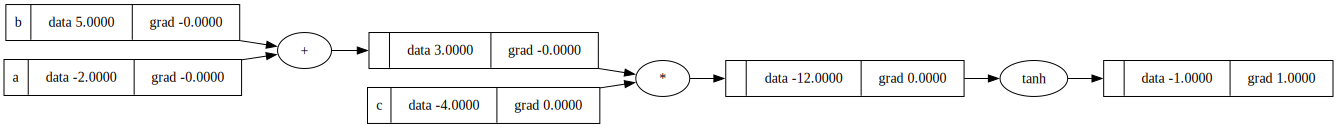

In [39]:
# Draw the graph
draw_dot(f)

Now let's move on to a simple neural network.

In [40]:
# Input values
x1 = Tensor(2.0, label='x1')
x2 = Tensor(3.0, label='x2')

# Weights
w1 = Tensor(-3.0, label='w1')
w2 = Tensor(1.0, label='w2')

# bias
b = Tensor(6.0, label='b')

# y = tanh(Wx + b) = tanh(w1*x1 + w2*x2 + b)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
y = x1w1x2w2 + b
y = y.tanh(); y.label = 'y'

In [41]:
# Calculate the gradient of y with respect to w1, w2, and b
y.backward()
print(f"y: {y.data}")
print(f"dy/dw1: {w1.gradient}")
print(f"dy/dw2: {w2.gradient}")
print(f"dy/db: {b.gradient}")

y: 0.9950547536867305
dy/dw1: 0.019732074330880423
dy/dw2: 0.029598111496320634
dy/db: 0.009866037165440211


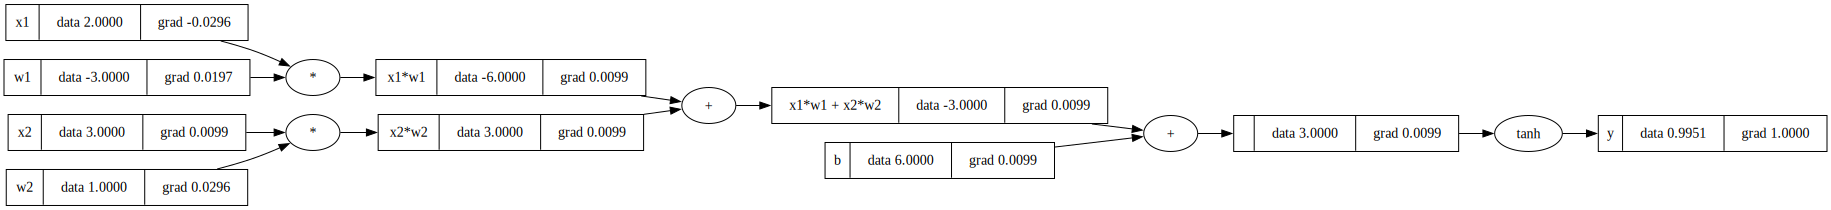

In [42]:
# Draw the graph
draw_dot(y)

### PyTorch Tensor

PyTorch is a popular deep learning library that provides a tensor object similar to the one we've implemented.

Let's implement the same example using PyTorch tensors.

In [43]:
import torch
# Implement PyTorch tensor
x1 = torch.tensor(2.0, requires_grad=False)
x2 = torch.tensor(3.0, requires_grad=False)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.0, requires_grad=True)
y = torch.tanh(w1 * x1 + w2 * x2 + b)

# Calculate the gradient of y with respect to w1, w2, and b
print(f"y: {y.data.item()}")
y.backward()
print(f"dy/dw1: {w1.grad.item()}")
print(f"dy/dw2: {w2.grad.item()}")
print(f"dy/db: {b.grad.item()}")

y: 0.9950547814369202
dy/dw1: 0.01973196305334568
dy/dw2: 0.029597945511341095
dy/db: 0.00986598152667284


## Part 2: Linear Regression

Linear regression is a simple machine learning model that predicts the relationship between two variables.

Let's implement a simple linear regression model using our custom tensor object. Then, we will train the model using the backpropagation algorithm.

### Model



In [44]:
# Linear network
class Linear:
    def __init__(self, input_size):
        # y = Wx + b
        self.weights = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]  # (input_size)
        self.bias = Tensor(random.uniform(-1, 1))  # (1)

    def __call__(self, x):
        """
        Forward pass
        y = Wx + b
        """
        x = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)  # matrix multiplication by summing the products
        # note: Dot product is not good for parallelization
        x = x.tanh()
        return x

    def parameters(self):
        return self.weights + [self.bias]

In [45]:
# Input values
x = [Tensor(-2.0), Tensor(5.0), Tensor(-4.0), Tensor(1.0)]

# Target value
y = Tensor(1.0)

# Initialize the linear network
linear = Linear(input_size=4)

# Example forward pass
print(f"Output: {linear(x)}")

Output: tensor=(0.9993831824962418)


### Training

Training a neural network involves the following steps:
1. Forward pass: Calculate the predicted value.
2. Loss: Calculate the difference between the predicted value and the target value.
3. Backward pass: Calculate the gradient of the loss with respect to the weights.
4. Update weights: Update the weights using the gradients.

Repeat the process until the loss is minimized.

Let's implement a simple training loop for the linear regression model.


In [47]:
lr = 1  # Learning rate

# Training loop
for step in range(10):
    # Forward pass
    logits = linear(x)
    
    # Loss
    loss = (logits - y) ** 2  # MSE loss

    # Backward pass
    for param in linear.parameters():
        param.gradient = 0  # Zero the gradients
    loss.backward()

    # Update weights
    for param in linear.parameters():
        param.data = param.data - lr * param.gradient

    print(f"Step {step+1}, Loss: {loss.data}")

Step 1, Loss: 3.8035507556175117e-07
Step 2, Loss: 3.8024636635447374e-07
Step 3, Loss: 3.801377192646758e-07
Step 4, Loss: 3.8002913423912675e-07
Step 5, Loss: 3.7992061122462337e-07
Step 6, Loss: 3.798121501679901e-07
Step 7, Loss: 3.7970375101621575e-07
Step 8, Loss: 3.795954137164532e-07
Step 9, Loss: 3.794871382156093e-07
Step 10, Loss: 3.7937892446089166e-07
